# Starbucks Customer Segmentation in Response to Offer Type

## Context

The data set used in this challenge contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Not all users receive the same offer, and that is the challenge to solve with this data set.

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. We'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, we can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer. This makes cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

We are free to analyze the data any way we see fit. For example, we could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or we could build a model that predicts whether or not someone will respond to an offer. Or, we don't need to build a machine learning model at all. We could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Pre-processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import math
import json
# import shap
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from xgboost import XGBRegressor, plot_importance
from mpl_toolkits.mplot3d import Axes3D

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Cleaning `portfolio` data set

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio_channels = pd.get_dummies(pd.DataFrame(portfolio['channels'].values.tolist()).stack()).sum(level=0)
portfolio = pd.concat([portfolio.drop(['channels'], axis=1), portfolio_channels], axis=1 )
portfolio['offer_combo'] = portfolio[['offer_type', 'reward', 'difficulty', 'duration']].astype(str).agg('_'.join, axis=1)
portfolio 

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,offer_combo
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,discount_2_10_7


### Cleaning `profile` data set

There are about 2,175 observations that don't have any info about the customers' `gender`, `income` and argueably `age` (since this variable only takes the value of 118, which seems unlikely in this case). Thus, we remove all these rows from the `profile` dataset. 

In [5]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [6]:
print('Earliest membership date: ', profile['became_member_on'].min())
print('Most recent membership date:', profile['became_member_on'].max())

Earliest membership date:  20130729
Most recent membership date: 20180726


In [7]:
profile[profile['gender'].isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [8]:
profile = (
    profile
#     .query('~gender.isnull()', engine='python')
    .assign(member_year=profile['became_member_on'].astype(str).str[:4].astype(int),
           member_month=profile['became_member_on'].astype(str).str[4:6].astype(int),
           member_date=profile['became_member_on'].astype(str).str[6:8].astype(int))
    .drop(['became_member_on'], axis=1)
)
profile

,gender,age,id,income,member_year,member_month,member_date
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,2016,3,7


In [9]:
# no NAs values
profile.isnull().mean()

gender          0.0
age             0.0
id              0.0
income          0.0
member_year     0.0
member_month    0.0
member_date     0.0
dtype: float64

In [10]:
# no duplicated rows
sum(profile.duplicated())

0

### Cleaning `transcript` data set

In [11]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [41]:
def process_transcript(event_type):
    val_text = 'offer ' + event_type
    time_col = 'offer_' + event_type + '_time'
#     count_col = event_type + '_count'
    key = 'offer_id' if event_type == 'completed' else 'offer id'
    data = (
        transcript
        .query('event == @val_text')
        .assign(offer_id=lambda x: [d.get(key) for d in x['value']])
        .rename(columns={'time': time_col})
        .filter(['person', 'offer_id', time_col])
#         .assign(tmp=lambda x: x.groupby(['person'])[time_col].transform('count'))
#         .rename(columns={'tmp': count_col})
    )
    return data

def create_offer_count_features(data, event_type):
    old_col_name = 'offer_' + event_type + '_time'
    new_col_name = event_type + '_count'
    prefix = event_type + '_count_'
    grouped_data = (
        data
        .groupby(['person', 'offer_id'])
        .agg('count')
        .reset_index()
        .rename(columns={old_col_name: new_col_name})
        .merge(portfolio[['id', 'offer_combo']], how='left', left_on='offer_id', right_on='id')
        .filter(['person', 'offer_combo', new_col_name])
        .pivot(index='person', columns='offer_combo', values=new_col_name)
        .add_prefix(prefix)
        .reset_index()
        .fillna(0)
    )
    return grouped_data

In [43]:
offer_received

,person,offer_id,offer_received_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0
...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,ae264e3637204a6fb9bb56bc8210ddfd,576
257883,cb23b66c56f64b109d673d5e56574529,2906b810c7d4411798c6938adc9daaa5,576
257884,6d5f3a774f3d4714ab0c092238f3a1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,576
257885,9dc1421481194dcd9400aec7c9ae6366,ae264e3637204a6fb9bb56bc8210ddfd,576


In [33]:
# those who received the offers 
offer_received = process_transcript('received')

# those who viewed the offers
offer_viewed = process_transcript('viewed')

# those who completed the offers; note that this might include who didn't view, 
# thus didn't get affected by the offer
offer_completed = process_transcript('completed')

In [181]:
transactions = (
    transcript
    .query('event == "transaction"')
    .assign(amount=lambda x: [d.get('amount') for d in x['value']])
    .rename(columns={'time': 'transaction_time'})
    .filter(['person', 'amount', 'transaction_time'])
    .sort_values(by=['person', 'transaction_time'])
    .assign(between_time=lambda x: x.groupby('person')['transaction_time'].transform(lambda x: x.diff()))
)

grouped_transactions = (
    transactions
    .groupby('person')
    .agg({'amount': ['count', 'sum', 'mean'], 'between_time': 'mean'})
    .reset_index()
    .droplevel(1, axis=1) 
)
grouped_transactions.columns = ['person', 'num_transactions', 'total_spent', 'mean_spent', 'mean_between_time']
grouped_transactions

,person,num_transactions,total_spent,mean_spent,mean_between_time
0,0009655768c64bdeb2e877511632db8f,8,127.60,15.950000,66.857143
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,1.363333,90.000000
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,15.892000,130.500000
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,24.607500,93.428571
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,12.837500,57.272727
...,...,...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,11,580.98,52.816364,54.600000
16574,fff7576017104bcc8677a8d63322b5e1,6,29.94,4.990000,132.000000
16575,fff8957ea8b240a6b5e634b6ee8eafcf,5,12.15,2.430000,139.500000
16576,fffad4f4828548d1b5583907f2e9906b,12,88.83,7.402500,58.363636


In [183]:
transactions

,person,amount,transaction_time,between_time
89291,0009655768c64bdeb2e877511632db8f,22.16,228,NaN
168412,0009655768c64bdeb2e877511632db8f,8.57,414,186.0
228422,0009655768c64bdeb2e877511632db8f,14.11,528,114.0
237784,0009655768c64bdeb2e877511632db8f,13.56,552,24.0
258883,0009655768c64bdeb2e877511632db8f,10.27,576,24.0
...,...,...,...,...
200255,ffff82501cea40309d5fdd7edcca4a07,13.17,498,84.0
214716,ffff82501cea40309d5fdd7edcca4a07,7.79,504,6.0
258361,ffff82501cea40309d5fdd7edcca4a07,14.23,576,72.0
274809,ffff82501cea40309d5fdd7edcca4a07,10.12,606,30.0


In [14]:
# those who completed the offers after viewing them and were eligible for rewards
completed_viewers = (
    offer_viewed
    .merge(offer_completed, how='left', on=['person', 'offer_id'])
    .query('offer_completed_time.notnull()', engine='python')
    .assign(completed_duration=lambda x: (x['offer_completed_time']-x['offer_viewed_time']) / 24)
    .merge(portfolio, how='left', left_on='offer_id', right_on='id')
    .query('0 <= completed_duration <= duration')
    .merge(transactions, how='left', left_on=['person', 'offer_completed_time'], right_on=['person', 'transaction_time'])
    .assign(mean_completed_time=lambda x: x.groupby(['person', 'offer_id'])['completed_duration'].transform('mean'))
    .merge(grouped_transactions, how='left', on='person')
)
completed_viewers

,person,offer_id,offer_viewed_time,viewed_count,offer_completed_time,completed_count,completed_duration,reward,difficulty,duration,...,mobile,social,web,offer_combo,amount,transaction_time,mean_completed_time,num_transactions,mean_spent,total_spent
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,2,60.0,2.0,2.50,5,5,5,...,1,1,1,bogo_5_5_5,9.54,60,3.25,3,12.143333,36.43
1,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,6.0,1.0,0.25,10,10,5,...,1,1,1,bogo_10_10_5,19.88,6,0.25,14,15.249286,213.49
2,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,1,0.0,1.0,0.00,2,10,7,...,1,0,1,discount_2_10_7,34.56,0,0.00,12,26.706667,320.48
3,8c7df0c393db488aac3e58b06a7ea5f9,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,36.0,1.0,1.50,3,7,7,...,1,1,1,discount_3_7_7,26.57,36,1.50,9,18.653333,167.88
4,53bac762af27471eb294ff89ca1bae2c,fafdcd668e3743c1bb461111dcafc2a4,0,1,216.0,1.0,9.00,2,10,10,...,1,1,1,discount_2_10_10,4.72,216,9.00,7,2.351429,16.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25196,7561a0a081e64e118bbc78818c890ab7,2906b810c7d4411798c6938adc9daaa5,696,1,696.0,1.0,0.00,2,10,7,...,1,0,1,discount_2_10_7,12.25,696,0.00,4,166.012500,664.05
25197,f86af496c16140a5a9e4fbe605a27bb5,ae264e3637204a6fb9bb56bc8210ddfd,696,1,714.0,1.0,0.75,10,10,7,...,1,1,0,bogo_10_10_7,22.14,714,0.75,6,24.360000,146.16
25198,845c31e647b449479f30b36eac5c5856,2906b810c7d4411798c6938adc9daaa5,702,1,714.0,1.0,0.50,2,10,7,...,1,0,1,discount_2_10_7,2.46,714,0.50,16,4.173750,66.78
25199,75ce7d71302e4e97af9bbeaebdd9ca9f,2906b810c7d4411798c6938adc9daaa5,708,1,714.0,1.0,0.25,2,10,7,...,1,0,1,discount_2_10_7,14.28,714,0.25,9,7.787778,70.09


## Q1: Relationship between Spending vs Demographics and Offer Type

#### Exploration: spending based on demographics

In [15]:
def cut_age(value):
    if 18 <= value < 25:
        new = '18-24'
    elif 25 <= value < 35:
        new = '25-34'
    elif 35 <= value < 45:
        new = '35-44'
    elif 45 <= value < 55:
        new = '45-54'
    elif 55 <= value < 65:
        new = '55-64'
    elif 65 <= value < 75:
        new = '65-74'
    else:
        new = '75+'
    return new

def cut_income(value):
    if 30000 <= value < 35000:
        new = '30-35k'
    elif 35000 <= value < 50000:
        new = '35-50k'
    elif 50000 <= value < 75000:
        new = '50-75k'
    elif 75000 <= value < 100000:
        new = '75-100k'
    else:
        new = '100k+'
    return new

In [16]:
# note that we use the original `transactions` dataset here for the analysis, instead of the subset `completed_viewers`
# since we don't care much about whether a customer was influenced by an offer or not at this point yet
# we only care about their demographics and how much they spent
trans_demog = (
    transactions
    .groupby(['person'])
    .agg({'amount': 'sum'})
    .reset_index()
    .merge(profile, how='inner', left_on='person', right_on='id')
    .assign(age_bin=lambda x: x['age'].apply(cut_age),
           income_bin=lambda x: x['income'].apply(cut_income))
)
trans_demog

,person,amount,gender,age,id,income,member_year,member_month,member_date,age_bin,income_bin
0,0009655768c64bdeb2e877511632db8f,127.60,M,33,0009655768c64bdeb2e877511632db8f,72000.0,2017,4,21,25-34,50-75k
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,O,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,2018,1,9,35-44,50-75k
2,0020c2b971eb4e9188eac86d93036a77,196.86,F,59,0020c2b971eb4e9188eac86d93036a77,90000.0,2016,3,4,55-64,75-100k
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,F,24,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,2016,11,11,18-24,50-75k
4,003d66b6608740288d6cc97a6903f4f0,48.34,F,26,003d66b6608740288d6cc97a6903f4f0,73000.0,2017,6,21,25-34,50-75k
...,...,...,...,...,...,...,...,...,...,...,...
14487,fff3ba4757bd42088c044ca26d73817a,580.98,F,69,fff3ba4757bd42088c044ca26d73817a,83000.0,2015,9,20,65-74,75-100k
14488,fff7576017104bcc8677a8d63322b5e1,29.94,M,71,fff7576017104bcc8677a8d63322b5e1,73000.0,2017,10,31,65-74,50-75k
14489,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,M,71,fff8957ea8b240a6b5e634b6ee8eafcf,56000.0,2018,2,18,65-74,50-75k
14490,fffad4f4828548d1b5583907f2e9906b,88.83,M,34,fffad4f4828548d1b5583907f2e9906b,34000.0,2017,1,23,25-34,30-35k


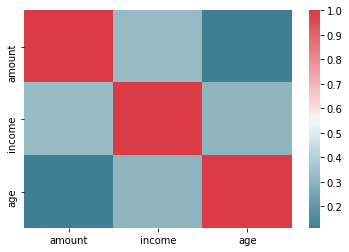

In [17]:
corr = trans_demog[['amount', 'income', 'age']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

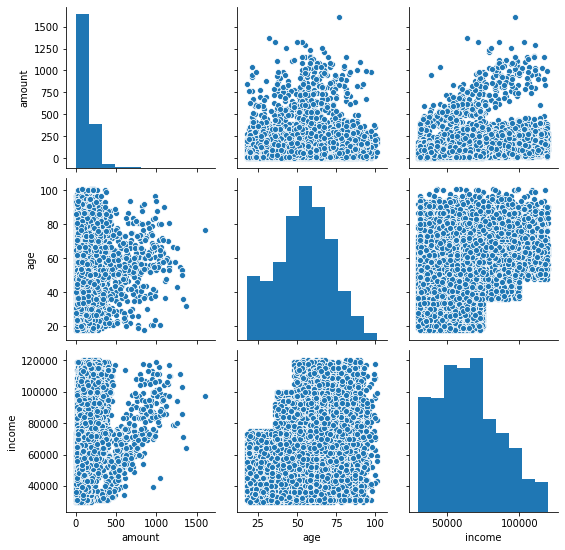

In [18]:
sns.pairplot(trans_demog[['amount', 'gender', 'age', 'income']])

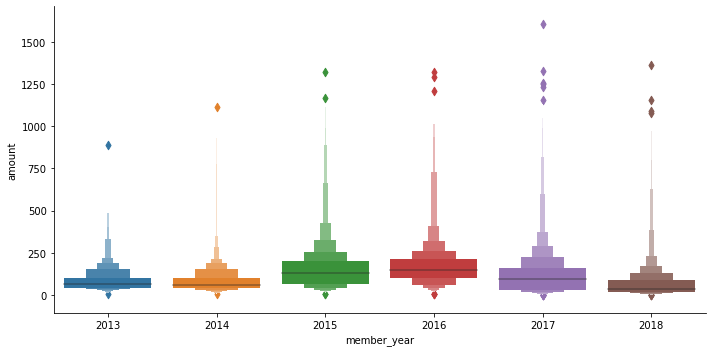

In [19]:
sns.catplot('member_year', 'amount', kind='boxen', data=trans_demog, height=5, aspect=2)

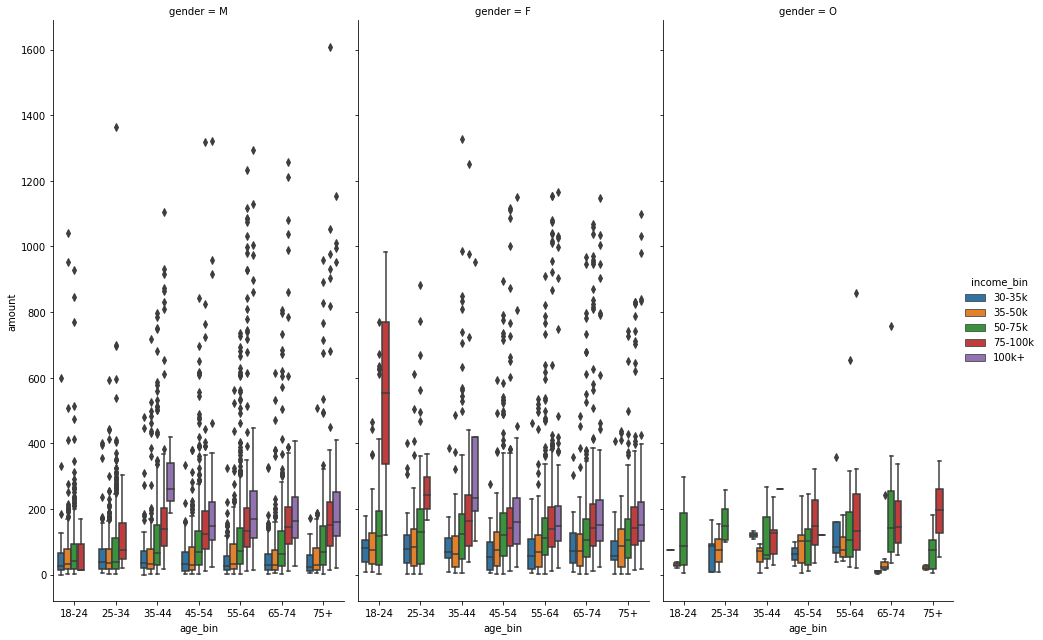

In [20]:
sns.catplot(x='age_bin', y='amount', hue ='income_bin', col='gender', kind='box',
            data=trans_demog.sort_values(['age_bin', 'income_bin']), height=9, aspect=0.5)

#### Exploration: spending based on offer type

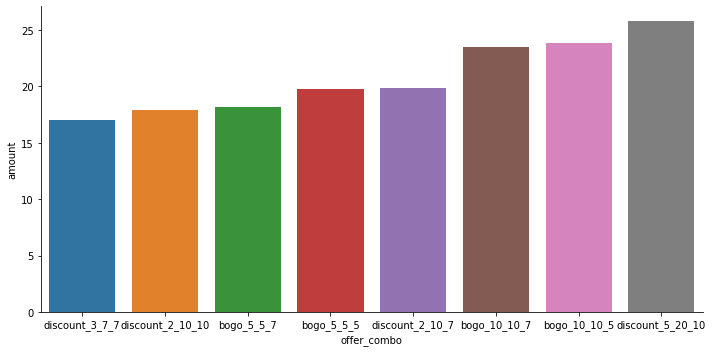

In [23]:
# the dataset used for analysis here only restricts to customers who were influenced by the offers
spend_offer = (
    completed_viewers
    .groupby(['offer_combo'])['amount']
    .aggregate(np.mean)
    .reset_index()
    .sort_values('amount')
)
sns.catplot(x='offer_combo', y='amount', kind='bar', data=spend_offer, 
            order=spend_offer['offer_combo'], height=5, aspect=2)

#### Modeling: predict how much someone will spend based on demographics and offer type

In [25]:
# note that in this dataset, one person can appear multiple times but the amount they spent might be different
# due to the different offer type, which makes it safe to assume that each row is independent of each other
modeling_data = (
    completed_viewers
    .merge(profile, how='inner', left_on='person', right_on='id')
    .filter(['viewed_count', 'completed_count', 'completed_duration', 'reward', 'difficulty', 
             'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'amount', 
             'mean_completed_time', 'num_transactions', 'gender', 'age', 'income', 
             'member_year', 'member_month', 'member_date'])
)
modeling_data = pd.get_dummies(modeling_data, columns=['offer_type', 'gender'], prefix_sep='_')

In [24]:
completed_viewers.columns

Index(['person', 'offer_id', 'offer_viewed_time', 'viewed_count',
       'offer_completed_time', 'completed_count', 'completed_duration',
       'reward', 'difficulty', 'duration', 'offer_type', 'id', 'email',
       'mobile', 'social', 'web', 'offer_combo', 'amount', 'transaction_time',
       'mean_completed_time', 'num_transactions', 'mean_spent', 'total_spent'],
      dtype='object')

In [26]:
y = modeling_data['amount']
X = modeling_data.iloc[:, modeling_data.columns != 'amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [28]:
y_pred = rf.predict(X_test)
print('R-squared of random forest model:', r2_score(y_test, y_pred))  # arbitrarily worse 

R-squared of random forest model: -0.05816801230279389


In [29]:
xb = XGBRegressor(random_state=42, learning_rate=0.01, n_estimators=500)
xb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [30]:
y_pred = xb.predict(X_test)
print('R-squared of Gradient Boosting model:', r2_score(y_test, y_pred))  

R-squared of Gradient Boosting model: 0.003575651827347315


In [ ]:
parameters = {'nthread': [4], #when use hyperthread, xgboost may become slower
              'objective': ['reg:squarederror'],
              'learning_rate': [.01, .03, 0.05, .1], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7, 1],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [1000]}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        n_jobs=5,
                        cv=5,
                        verbose=True)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
# pickle.dump(xgb_grid, open('xgb_cv.sav', 'wb'))
xgb_grid = pickle.load(open('xgb_cv.sav', 'rb'))

In [ ]:
xgb_grid.best_score_

In [ ]:
y_pred = xgb_grid.predict(X_test)
print('R-squared of Gradient Boosting model:', r2_score(y_test, y_pred))

In [ ]:
plot_importance(xgb_grid.best_estimator_, importance_type='weight')

In [ ]:
plot_importance(xgb_grid.best_estimator_, importance_type='gain')

In [ ]:
# # load JS visualization code to notebook
# shap.initjs()

# # explain the model's predictions using SHAP
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_train)

## Q2: Develop a set of heuristics that determine what offer you should send to each customer 

In [ ]:
clustering_data = modeling_data[['amount', 'gender', 'age', 'income',
                              'member_year', 'member_month', 'member_date']]
clustering_data = pd.get_dummies(clustering_data, columns=['gender'])
clustering_data

In [ ]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(clustering_data)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1, 11),wcss, linewidth=2, color='red', marker ='8')
plt.xlabel('k-value')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('WCSS')
plt.show()

In [ ]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(clustering_data)
clustering_data['label'] = clusters

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clustering_data[clustering_data['label'] == 0]['age'], 
           clustering_data[clustering_data['label'] == 0]['income'], 
           clustering_data[clustering_data['label'] == 0]['amount'], 
           c='blue', s=60)
ax.scatter(clustering_data[clustering_data['label'] == 1]['age'], 
           clustering_data[clustering_data['label'] == 1]['income'], 
           clustering_data[clustering_data['label'] == 1]['amount'], 
           c='red', s=60)
ax.scatter(clustering_data[clustering_data['label'] == 2]['age'], 
           clustering_data[clustering_data['label'] == 2]['income'], 
           clustering_data[clustering_data['label'] == 2]['amount'], 
           c='green', s=60)
plt.xlabel('Age')
plt.ylabel('Income')
ax.set_zlabel('Amount Spent')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(clustering_data[clustering_data['label']==0]['income'], 
            clustering_data[clustering_data['label']==0]['amount'], 
            s=50, c='red', label='Cluster1')
plt.scatter(clustering_data[clustering_data['label']==1]['income'], 
            clustering_data[clustering_data['label']==1]['amount'], 
            s=50, c='blue', label='Cluster2')
plt.scatter(clustering_data[clustering_data['label']==2]['income'], 
            clustering_data[clustering_data['label']==2]['amount'], 
            s=50, c='green', label='Cluster3')
plt.scatter(km.cluster_centers_[:,2], km.cluster_centers_[:,0], s=200, 
            marker='s', c='yellow', alpha=0.7, label='Centroids')
plt.xlabel('Income')
plt.ylabel('Amount Spent')
plt.legend()
plt.show()